In [2]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

In [4]:
gun_df = pd.read_csv('../mridul/data/gun-violence-data_01-2013_03-2018.csv')

In [5]:
print("Number of rows: " + str(len(gun_df)))
print("Number of columns: " + str(len(gun_df.columns)))

Number of rows: 239677
Number of columns: 29


There are 239,677 rows in the dataset. Each row contains information about a seperate gun violence incident, ranging from the latitude and longitude, details about perpetrators and victims, to house state and senate districts.
The csv file has 29 distinct columns.

Instead of predicting future gun violence incidents, we will create three models.

* Firstly, predicting the number of people injured based on incident characteristics,
* Secondly, predicting the number of people killed based on incident characteristics.
* Thirdly, predicting the number of casualties based on incident characteristics.

In order to complete this task we will use Linear Regresion model and fit some of the existing data to it and predict the numbers of desired category for the test set.

Evaluation metrics:

* Mean Squared Error which is the average squared difference between the predicted value and the actual value. Should be as low as possible.
* Mean Absolute Error which is a measure of the average magnitude of errors in a set of predictions, without considering their direction, calculated as the average of the absolute differences between predicted and actual values
* Explained variance which is a measure used in statistics to indicate the proportion of the total variance in a dataset that is accounted for by a statistical model, representing how well the model captures the variability of the observed data.
* R² Score (also known as coefficient of determination) which determines the proportion of variance in a dependent variable that can be predicted or explained by an independent variable. In order words it shows what percentage of predicted values was correct. Is in range from 0 to 1 and the greater the better.

# Data preprocessing

In the cell below, the `date` column is preprocessed into separate columns for `day`, `month`, `year`, `quarter` and `weekday`.

This should allow to get better accuracy for predictions based on the sense of each of them separately.

In [12]:
# Data preprocessing
interest_columns = ['date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'n_guns_involved', 'gun_type', 'latitude', 'longitude', 'gun_stolen', 'incident_characteristics']
gun_df = gun_df[interest_columns]

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
gun_df['date'] = pd.to_datetime(gun_df['date'], format='%m/%d/%Y')
gun_df['day'] = gun_df['date'].dt.day
gun_df['month'] = gun_df['date'].dt.month_name()
gun_df['month'] = pd.Categorical(gun_df['month'], categories=month_order, ordered=True)
gun_df['year'] = gun_df['date'].dt.year
gun_df['year'] = pd.Categorical(gun_df['year'], ordered=True)
gun_df['quarter'] = gun_df['date'].dt.quarter
gun_df['weekday'] = gun_df['date'].dt.weekday

gun_df = gun_df.drop("date", axis=1)

In the next step, the missing values are replaced with the specific placeholders.

In [14]:
# should be -1 because value needs to be diferent than 0 
# (there is no information for guns involved, not information that 0 guns were used)
gun_df['n_guns_involved'].fillna(-1, inplace=True)
gun_df['gun_stolen'].fillna('Unknown', inplace=True)
gun_df['gun_type'].fillna('Unknown', inplace=True)
gun_df['latitude'].fillna(0, inplace=True)
gun_df['longitude'].fillna(0, inplace=True)



To preprocess the data, the next step involves splitting the column `incident_characteristics` to separate each specific characteristic into its own column, indicating whether it occurred or not (1 for occurred, 0 for not occurred). This transformation will convert the data into wide format, with each new column prefixed with `flag_`. Finally, we will check for any missing values in the dataframe and drop the unnecessary column `incident_characteristics`.

In [16]:
# Separate incident characteristics into columns
def normalize_characteristic(c: str) -> str:
    return f"flag_{c.strip().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace(',', '').replace('/', '_').lower()}"


def preprocess_incident_characteristics(df):
    incident_characteristics = df['incident_characteristics'].fillna('')

    all_characteristics = set()
    for characteristics in incident_characteristics:
        for characteristic in characteristics.split('||'):
            if '|' in characteristics.strip():
                for entry in characteristic.strip().split('|'):
                    all_characteristics.add(normalize_characteristic(entry))
            else:
                all_characteristics.add(normalize_characteristic(characteristic))

    binary_columns_list = []

    for index, characteristics in incident_characteristics.items():
        binary_columns = {char: 0 for char in all_characteristics if len(char) != 0}
        for characteristic in characteristics.split('||'):
            cols = []
            if '|' in characteristics.strip():
                for entry in characteristic.strip().split('|'):
                    cols.append(normalize_characteristic(entry))
            else:
                cols.append(normalize_characteristic(characteristic))
            for col_name in cols:
                if col_name in binary_columns:
                    binary_columns[col_name] = 1

        binary_columns_list.append(binary_columns)

    characteristics_df = pd.DataFrame(binary_columns_list)
    df = pd.concat([df, characteristics_df], axis=1)

    # Drop processed columns
    df.drop(columns=['incident_characteristics', 'flag_'], inplace=True)

    return df

The next preprocessing step is similar to the previous one. The `gun_type` column also contains multiple values in a single cell. It will be processed so that each distinct weapon has its own column indicating the quantity of that type of gun used in the specific incident. Each new column representing the number of weapons will be prefixed with `weapon_`. Subsequently, the `gun_type` column can be removed.

In [20]:
# Expand gun type into separate columns
def expand_gun_type(gun_type):
    weapons = gun_type.split('||')
    weapon_dict = {}
    for weapon in weapons:
        parts = weapon.split('::')
        if len(parts) == 2:
            weapon_type = parts[1].strip()
            if weapon_type in weapon_dict:
                weapon_dict[f"weapon_{weapon_type}"] += 1
            else:
                weapon_dict[f"weapon_{weapon_type}"] = 1
    return pd.Series(weapon_dict)


def preprocess_gun_type(df):
    gun_type_expanded = df['gun_type'].apply(expand_gun_type)
    gun_type_expanded = gun_type_expanded.fillna(0)
    df = pd.concat([df.drop('gun_type', axis=1), gun_type_expanded], axis=1)
    df = df.drop(['weapon_Unknown'], axis=1)

    return df

In [24]:
# Apply preprocessing steps to gun_df
gun_df = preprocess_incident_characteristics(gun_df)

In [26]:
gun_df = preprocess_gun_type(gun_df)

The last check if there are any missing values in the dataframe:

In [28]:
# Check for missing values in the dataframe
missing_values = gun_df.isnull().sum()

# Convert the missing values summary to a DataFrame
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'Missing Values']

# Display the DataFrame
missing_df


,Column,Missing Values
0,state,0
1,city_or_county,0
2,n_killed,0
3,n_injured,0
4,n_guns_involved,0
...,...,...
143,weapon_10mm,0
144,weapon_20 gauge,0
145,weapon_30-06 Spr,0
146,weapon_300 Win,0


In [29]:
# Verify if there are any missing values
if missing_df['Missing Values'].sum() == 0:
    print("\nNo missing values found in the dataset.")
else:
    print("\nThere are missing values in the dataset.")


No missing values found in the dataset.


In [30]:
print("Number of rows: " + str(len(gun_df)))
print("Number of columns: " + str(len(gun_df.columns)))

Number of rows: 239677
Number of columns: 148


We have managed to get rid of all the unknown values, keeping the size of the dataframe intact. However, the number of columns increased from 29 to 148, due to oneHotEncoding of the columns consisting of multiple values.

# Linear regression modelling

We will perform the linear regression for two attributes: 

* n_killed,
* n_injured,
* n_casualty

In [34]:
# Add y_casualty to the dataframe
gun_df['y_casualty'] = gun_df['n_killed'] + gun_df['n_injured']

features = [col for col in gun_df.columns if col not in ("n_killed", "n_injured", "y_casualty")]
X = gun_df[features]

y_killed = gun_df['n_killed']
y_injured = gun_df['n_injured']
y_casualty = gun_df['y_casualty']

categorical_features = ['day', 'month', 'year', 'quarter', 'weekday', 'state', 'city_or_county', 'gun_stolen', *[x for x in gun_df.columns if x.startswith("flag_")]]
numeric_features = ['latitude', 'longitude', 'n_guns_involved', *[x for x in gun_df.columns if x.startswith("weapon_")]]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Then dataset is splitted into testing and training sets.

In [36]:
X_injured_train, X_injured_test, y_injured_train, y_injured_test = train_test_split(X, y_injured, test_size=0.2, random_state=42)

X_killed_train, X_killed_test, y_killed_train, y_killed_test = train_test_split(X, y_killed, test_size=0.2, random_state=42)

X_casualty_train, X_casualty_test, y_casualty_train, y_casualty_test = train_test_split(X, y_casualty, test_size=0.2, random_state=42)

## Model fitting

Next, a pipeline is created for each model, comprising a preprocessing component (primarily one-hot encoding, as numerical values remain unchanged) and Linear Regression. Subsequently, each model is trained on the data.

In [38]:
injured_model = make_pipeline(preprocessor, LinearRegression())
killed_model = make_pipeline(preprocessor, LinearRegression())

injured_model.fit(X_injured_train, y_injured_train)
killed_model.fit(X_killed_train, y_killed_train)

casualty_model = make_pipeline(preprocessor, LinearRegression())
casualty_model.fit(X_casualty_train, y_casualty_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['latitude', 'longitude',
                                                   'n_guns_involved',
                                                   'weapon_Handgun',
                                                   'weapon_22 LR',
                                                   'weapon_223 Rem [AR-15]',
                                                   'weapon_Shotgun',
                                                   'weapon_9mm',
                                                   'weapon_45 Auto',
                                                   'weapon_12 gauge',
                                                   'weapon_7.62 [AK-47]',
                                                   'weapon_40 SW',
                                                   'weapon_44 Mag',
                                                   'weapon_Other',
                                                   'weapon_38 Spl',
                                                   'weapon_380 Auto',
                                                   'wea...
                                                   'flag_police_targeted',
                                                   'flag_suicide^',
                                                   'flag_spree_shooting_multiple_victims_multiple_locations',
                                                   'flag_officer_involved_incident',
                                                   'flag_guns_stolen_from_law_enforcement',
                                                   'flag_workplace_shooting_disgruntled_employee',
                                                   'flag_officer_involved_shooting___accidental_discharge___no_injury_required',
                                                   'flag_hate_crime', ...])])),
                ('linearregression', LinearRegression())])

## Results - Coefficients

The first step in examining the model's specifics involves accessing the combined list of all features used in the model training process.

In [41]:
onehot_categories = injured_model.named_steps['columntransformer'].named_transformers_['cat'].categories_
numeric_features_out = numeric_features
categorical_features_out = [f"{feature}_{category}" for feature, categories in zip(categorical_features, onehot_categories) for category in categories]
all_features = numeric_features_out + categorical_features_out

Next, we can access the computed coefficients and intercepts for each feature individually, for both models. We aim to display the list of the top 10 features that have the greatest impact on the prediction outcome.

In [43]:
coefficients_injured = injured_model.named_steps['linearregression'].coef_
intercept_injured = injured_model.named_steps['linearregression'].intercept_

summary_injured = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients_injured
})

# Sort by absolute value of coefficients
summary_injured['AbsCoefficient'] = summary_injured['Coefficient'].abs()
summary_injured_sorted = summary_injured.sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print("Intercept (Injured Model):", intercept_injured)
print(summary_injured_sorted.head(10))

Intercept (Injured Model): 4.656509547755472
                                       Feature  Coefficient
10503        city_or_county_Sutherland Springs    16.292501
8619   city_or_county_Pompano Beach (Parkland)     6.517898
1656                    city_or_county_Capulin    -3.157531
4214        city_or_county_Goleta (Isla Vista)     3.125521
5520                 city_or_county_Kilmichael    -3.062266
7128                  city_or_county_Montesano    -2.937501
6194             city_or_county_Lookout Valley    -2.930432
3443             city_or_county_Emery (county)    -2.923290
1231         city_or_county_Bradley (Callison)    -2.706491
2185             city_or_county_Clearlake Oaks    -2.563330


In [44]:
coefficients_killed = killed_model.named_steps['linearregression'].coef_
intercept_killed = killed_model.named_steps['linearregression'].intercept_

summary_killed = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients_killed
})

summary_killed['AbsCoefficient'] = summary_killed['Coefficient'].abs()
summary_killed_sorted = summary_killed.sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print("Intercept (Killed Model):", intercept_killed)
print(summary_killed_sorted.head(10))

Intercept (Killed Model): 5.520367821224573
                                                 Feature  Coefficient
10503                  city_or_county_Sutherland Springs    21.165704
8619             city_or_county_Pompano Beach (Parkland)     5.149141
11293                city_or_county_Washington Navy Yard     2.902459
3443                       city_or_county_Emery (county)    -2.590673
7128                            city_or_county_Montesano    -2.563481
8435                              city_or_county_Piketon     2.474956
12350  flag_mass_murder_4+_deceased_victims_excluding...     2.006434
12349  flag_mass_murder_4+_deceased_victims_excluding...    -2.006434
245                                city_or_county_Alexis     1.966197
1147                            city_or_county_Bondurant     1.963614


In [45]:
# Access the calculated coefficients and intercepts for the casualty model
coefficients_casualty = casualty_model.named_steps['linearregression'].coef_
intercept_casualty = casualty_model.named_steps['linearregression'].intercept_

summary_casualty = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients_casualty
})

# Sort by absolute value of coefficients
summary_casualty['AbsCoefficient'] = summary_casualty['Coefficient'].abs()
summary_casualty_sorted = summary_casualty.sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print("Intercept (Casualty Model):", intercept_casualty)
print(summary_casualty_sorted.head(10))

Intercept (Casualty Model): 10.15438747668391
                                                 Feature  Coefficient
10503                  city_or_county_Sutherland Springs    37.535643
8619             city_or_county_Pompano Beach (Parkland)    11.586649
3443                       city_or_county_Emery (county)    -5.537304
7128                            city_or_county_Montesano    -5.523248
1231                   city_or_county_Bradley (Callison)    -4.196508
4214                  city_or_county_Goleta (Isla Vista)     3.897857
11976  gun_stolen_0::Not-stolen||1::Not-stolen||2::No...     3.804086
11974            gun_stolen_0::Not-stolen||1::Not-stolen     3.796852
4630                              city_or_county_Hartsel    -3.762146
1410                               city_or_county_Bucoda    -3.691133


As we can see above, the feature_category which has the highest impact on the outcome of `n_killed` , `n_injured` and `n-casualty` was the value "Sutherland Springs" in the column `city_or_county`.

There is a noticeable effect of the `city_or_county` column on the outcome. It seems that the `n_killed` and `n_injured` is highly connected with the location of the incident.

## Evaluation of the linear regression model

In [48]:
y_inj_pred = injured_model.predict(X_injured_test)
y_kill_pred = killed_model.predict(X_killed_test)
y_cas_pred = casualty_model.predict(X_casualty_test)

mse_injured = metrics.mean_squared_error(y_inj_pred, y_injured_test)
mse_killed = metrics.mean_squared_error(y_kill_pred, y_killed_test)
mse_casualty = metrics.mean_squared_error(y_cas_pred, y_casualty_test)

mean_absolute_error_injured = metrics.mean_absolute_error(y_inj_pred, y_injured_test) 
mean_absolute_error_killed = metrics.mean_absolute_error(y_kill_pred, y_killed_test)
mean_absolute_error_casualty = metrics.mean_absolute_error(y_cas_pred, y_casualty_test)

explained_variance_injured = metrics.explained_variance_score(y_inj_pred, y_injured_test)
explained_variance_killed = metrics.explained_variance_score(y_kill_pred, y_killed_test)
explained_variance_casualty = metrics.explained_variance_score(y_cas_pred, y_casualty_test)

r2_injured = metrics.r2_score(y_injured_test, y_inj_pred)
r2_killed = metrics.r2_score(y_killed_test, y_kill_pred)
r2_casualty = metrics.r2_score(y_casualty_test, y_cas_pred)

print("Injured linear regression:")
print(f'Mean squared error: {mse_injured}')
print(f'Mean absolute error: {mean_absolute_error_injured}')
print(f'Explained variance: {explained_variance_injured}')
print("R² Score for Injured Predictions:", r2_injured)
print("---------------------------------------------------")
print("Killed linear regression:")
print(f'Mean squared error: {mse_killed}')
print(f'Mean absolute error: {mean_absolute_error_killed}')
print(f'Explained variance: {explained_variance_killed}')
print("R² Score for Killed Predictions:", r2_killed)
print("---------------------------------------------------")
print("Casualty linear regression:")
print(f'Mean squared error: {mse_casualty}')
print(f'Mean absolute error: {mean_absolute_error_casualty}')
print(f'Explained variance: {explained_variance_casualty}')
print("R² Score for Casualty Predictions:", r2_casualty)

Injured linear regression:
Mean squared error: 0.11983357555433104
Mean absolute error: 0.15897260986152315
Explained variance: 0.7084268823707855
R² Score for Injured Predictions: 0.765886792212995
---------------------------------------------------
Killed linear regression:
Mean squared error: 0.02684879129494014
Mean absolute error: 0.045620338561336585
Explained variance: 0.8866308363844261
R² Score for Killed Predictions: 0.8949783873358372
---------------------------------------------------
Casualty linear regression:
Mean squared error: 0.1436721014713774
Mean absolute error: 0.1814732615597525
Explained variance: 0.7323635808373932
R² Score for Casualty Predictions: 0.7753720225256618


As we can see, the models performance looks promising. However, the `n_killed` linear regression model seems to perform better with mean square error of 0.027 and R^2 score of 0.89 which shows that the model explains 89% of the variability of number of killed people.

The next step is testing the models' work:

In [51]:
# Set the seed for reproducibility
np.random.seed(10)

# Number of samples to compare
num_samples = 10

y_injured_test_array = y_injured_test.to_numpy(dtype="float32")
y_killed_test_array = y_killed_test.to_numpy(dtype="float32")
y_casualty_test_array = y_casualty_test.to_numpy(dtype="float32")

# Generate random indices
random_indices = np.random.choice(len(y_killed_test_array), num_samples, replace=False)


# Print the comparison for injured predictions
print("\nComparison of Injured Predictions and Actual Values:")
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {y_inj_pred[idx]}, Actual: {y_injured_test_array[idx]}, Difference: {abs(y_inj_pred[idx]-y_injured_test_array[idx])}")

# Print the comparison for killed predictions
print("\nComparison of Killed Predictions and Actual Values:")
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {y_kill_pred[idx]}, Actual: {y_killed_test_array[idx]}, Difference: {abs(y_kill_pred[idx]-y_killed_test_array[idx])}")

# Print the comparison for casualty predictions
print("\nComparison of Casualty Predictions and Actual Values:")
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {y_cas_pred[idx]}, Actual: {y_casualty_test_array[idx]}, Difference: {abs(y_cas_pred[idx]-y_casualty_test_array[idx])}")


Comparison of Injured Predictions and Actual Values:
Index: 28059, Predicted: -0.05143325572634261, Actual: 0.0, Difference: 0.05143325572634261
Index: 34957, Predicted: 1.0296449639937242, Actual: 1.0, Difference: 0.029644963993724183
Index: 5639, Predicted: -0.005969895733952235, Actual: 0.0, Difference: 0.005969895733952235
Index: 34688, Predicted: -0.018915271299326797, Actual: 0.0, Difference: 0.018915271299326797
Index: 17834, Predicted: -0.01931897185021647, Actual: 0.0, Difference: 0.01931897185021647
Index: 30789, Predicted: 0.02512529612458536, Actual: 0.0, Difference: 0.02512529612458536
Index: 13259, Predicted: 1.0800471172670791, Actual: 1.0, Difference: 0.08004711726707914
Index: 11296, Predicted: 0.06076995648399208, Actual: 0.0, Difference: 0.06076995648399208
Index: 42540, Predicted: -0.041864954483163075, Actual: 0.0, Difference: 0.041864954483163075
Index: 8827, Predicted: 1.1071804363230484, Actual: 1.0, Difference: 0.10718043632304841

Comparison of Killed Predict

In this step we have shown randomized rows, and compared the predicted values with the actual values.

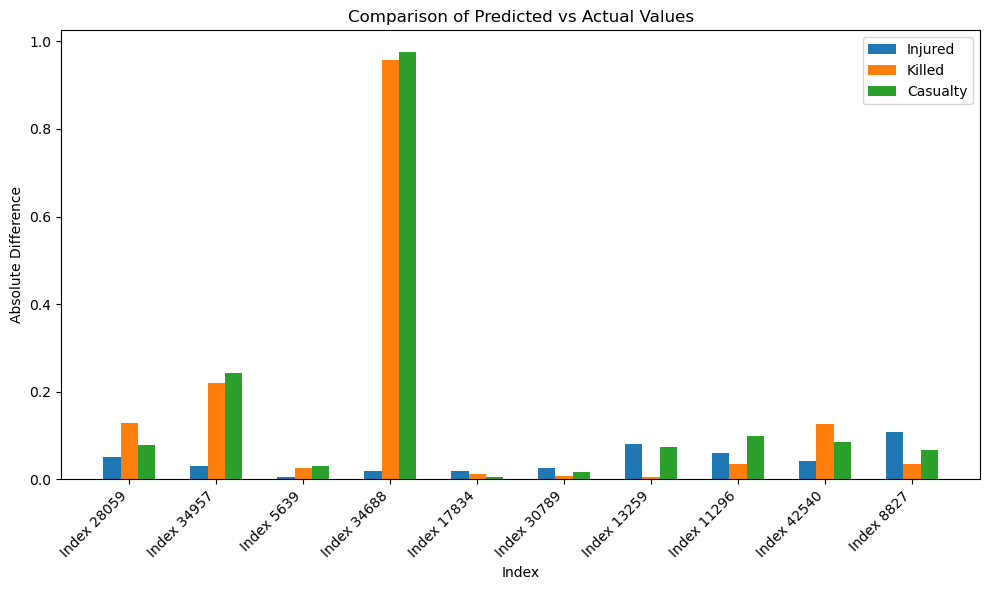

In [53]:
import matplotlib.pyplot as plt

# Create a bar plot for the absolute differences
fig, ax = plt.subplots(figsize=(10, 6))

indices = [f'Index {idx}' for idx in random_indices]
injured_differences = [abs(y_inj_pred[idx] - y_injured_test_array[idx]) for idx in random_indices]
killed_differences = [abs(y_kill_pred[idx] - y_killed_test_array[idx]) for idx in random_indices]
casualty_differences = [abs(y_cas_pred[idx] - y_casualty_test_array[idx]) for idx in random_indices]

bar_width = 0.2
index = range(num_samples)

bar1 = plt.bar(index, injured_differences, bar_width, label='Injured')
bar2 = plt.bar([i + bar_width for i in index], killed_differences, bar_width, label='Killed')
bar3 = plt.bar([i + 2*bar_width for i in index], casualty_differences, bar_width, label='Casualty')

plt.xlabel('Index')
plt.ylabel('Absolute Difference')
plt.title('Comparison of Predicted vs Actual Values')
plt.xticks([i + bar_width for i in index], indices, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

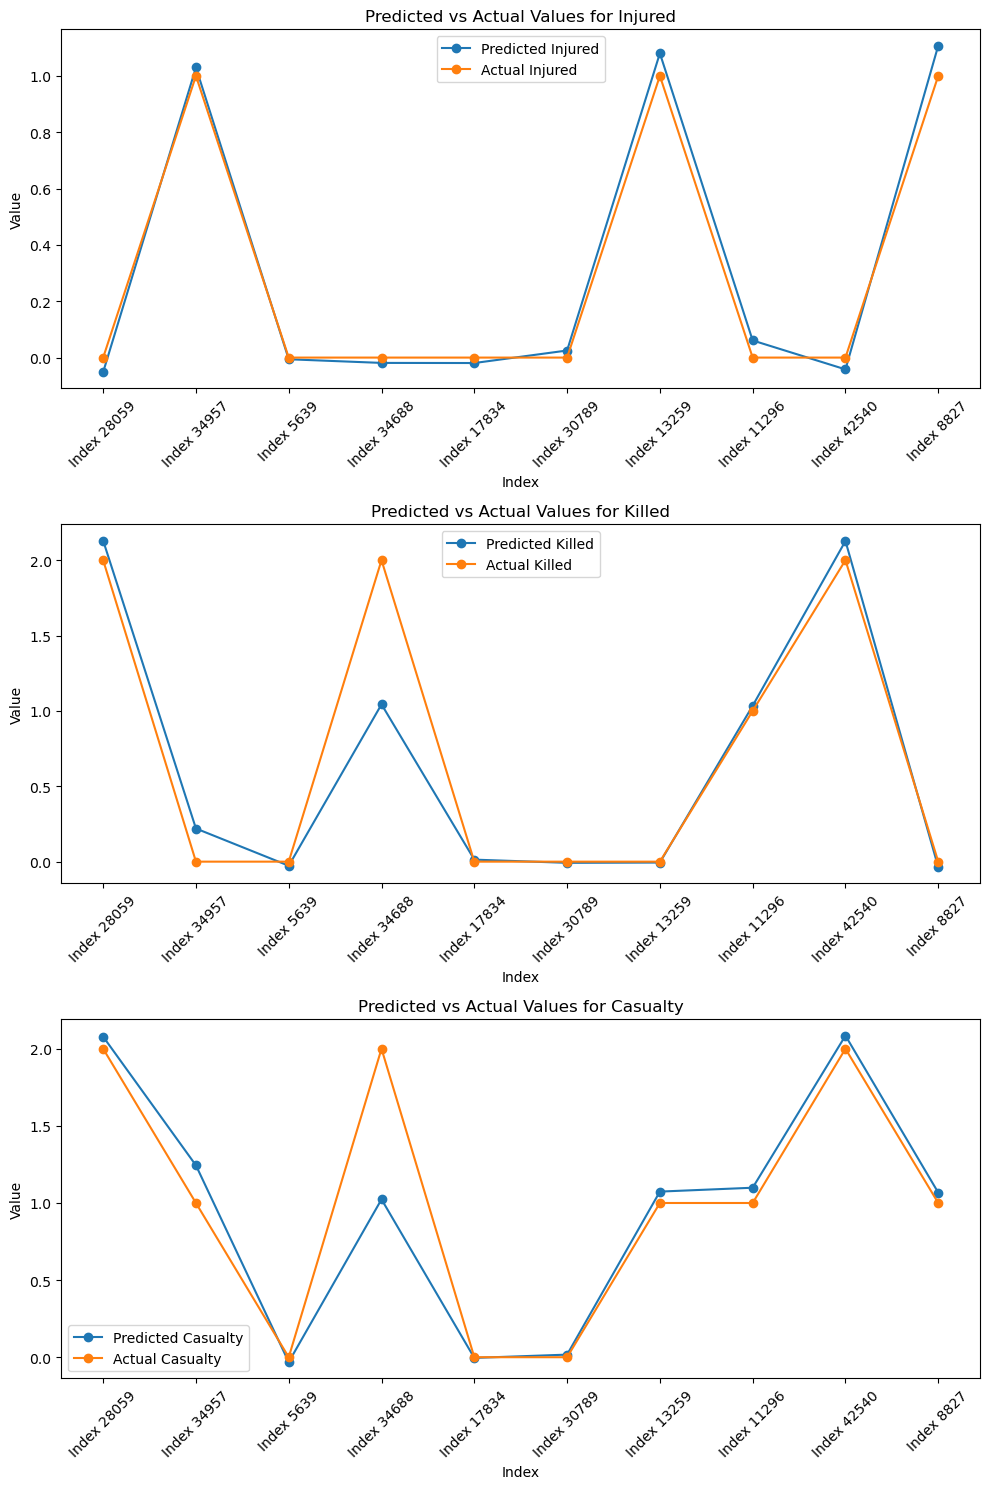

In [54]:
import matplotlib.pyplot as plt

# Create three separate line graphs for each category
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

indices = [f'Index {idx}' for idx in random_indices]

# Plot for Injured category
axs[0].plot(indices, y_inj_pred[random_indices], label='Predicted Injured', marker='o', linestyle='-')
axs[0].plot(indices, y_injured_test_array[random_indices], label='Actual Injured', marker='o', linestyle='-')
axs[0].set_title('Predicted vs Actual Values for Injured')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

# Plot for Killed category
axs[1].plot(indices, y_kill_pred[random_indices], label='Predicted Killed', marker='o', linestyle='-')
axs[1].plot(indices, y_killed_test_array[random_indices], label='Actual Killed', marker='o', linestyle='-')
axs[1].set_title('Predicted vs Actual Values for Killed')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)

# Plot for Casualty category
axs[2].plot(indices, y_cas_pred[random_indices], label='Predicted Casualty', marker='o', linestyle='-')
axs[2].plot(indices, y_casualty_test_array[random_indices], label='Actual Casualty', marker='o', linestyle='-')
axs[2].set_title('Predicted vs Actual Values for Casualty')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')
axs[2].legend()
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()